<font color ='brown'>
    

    
### Load and Check Data 

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/brain'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

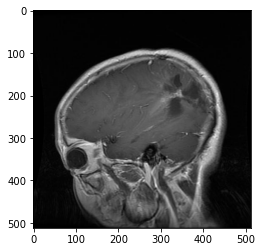

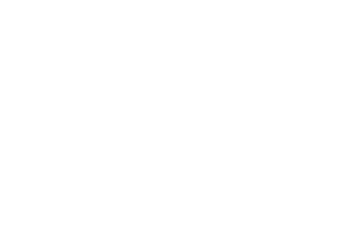

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

DATADIR = r"/kaggle/input/brain-tumor-classification-mri/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

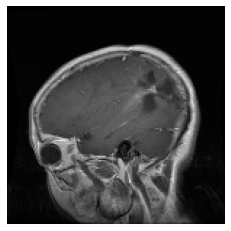

In [3]:
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")


### MANIPULATING DATA

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [5]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2870, 150, 150)


In [6]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 4)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2296, 150, 150, 1)
x_test shape (574, 150, 150, 1)
y_train shape (2296, 4)
y_test shape (574, 4)


### PREDICTION USING CNN

In [8]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
#
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# 
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50  
batch_size = 40
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [9]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

Epoch 1/50
57/57 [==============================] - 3s 51ms/step - loss: 1.3171 - accuracy: 0.3679 - val_loss: 1.1759 - val_accuracy: 0.5017
Epoch 2/50
57/57 [==============================] - 2s 40ms/step - loss: 1.0589 - accuracy: 0.5412 - val_loss: 1.0044 - val_accuracy: 0.5767
Epoch 3/50
57/57 [==============================] - 2s 40ms/step - loss: 0.8434 - accuracy: 0.6356 - val_loss: 0.7801 - val_accuracy: 0.6742
Epoch 4/50
57/57 [==============================] - 2s 40ms/step - loss: 0.7825 - accuracy: 0.6676 - val_loss: 0.7568 - val_accuracy: 0.6760
Epoch 5/50
57/57 [==============================] - 2s 40ms/step - loss: 0.6934 - accuracy: 0.6875 - val_loss: 0.7335 - val_accuracy: 0.6603
Epoch 6/50
57/57 [==============================] - 2s 40ms/step - loss: 0.6159 - accuracy: 0.7398 - val_loss: 0.6256 - val_accuracy: 0.7369
Epoch 7/50
57/57 [==============================] - 2s 40ms/step - loss: 0.5790 - accuracy: 0.7504 - val_loss: 0.5968 - val_accuracy: 0.7613
Epoch 8/50
57

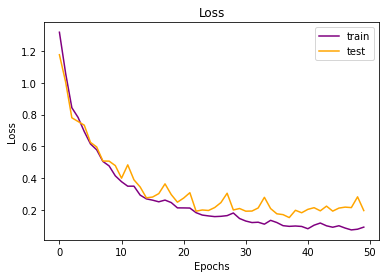

In [10]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

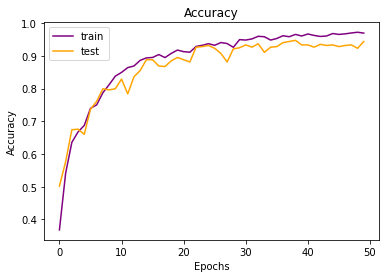

In [11]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()